# Train Channel Reduction

- Train deep classifiers for the EEG-based diagnostic classification with channel reduction.
    - CAUEEG-Dementia benchmark: Classification of **Normal**, **MCI**, and **Dementia** symptoms
    - CAUEEG-Abnormal benchmark: Classification of **Normal** and **Abnormal** symptoms    

-----

## Load Packages

In [1]:
# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2
%cd ..

C:\Users\Minjae\Desktop\EEG_Project


In [2]:
# Load some packages
import hydra
from omegaconf import OmegaConf
import wandb
import pprint
from copy import deepcopy
import itertools
from tqdm.auto import tqdm

# custom package
from run_train import check_device_env
from run_train import prepare_and_run_train

---

## Specify the dataset, model, and train setting

In [3]:
script = "data=caueeg-dementia data.EKG=O data.awgn=0 data.awgn_age=0 data.mgn=0 data.photic=O data.seq_length=2000 model=1D-ResNet-18 model.activation=gelu model.dropout=0.3 model.fc_stages=3 model.use_age=conv train.criterion=multi-bce train.lr_scheduler_type=cosine_decay_with_warmup_half train.mixup=0.2 train.weight_decay=0.04394746639552375 ++train.project=caueeg-task2-ablation ++train.base_lr=0.00046936536527944847 ++train.search_lr=False"
print(script)

data=caueeg-dementia data.EKG=O data.awgn=0 data.awgn_age=0 data.mgn=0 data.photic=O data.seq_length=2000 model=1D-ResNet-18 model.activation=gelu model.dropout=0.3 model.fc_stages=3 model.use_age=conv train.criterion=multi-bce train.lr_scheduler_type=cosine_decay_with_warmup_half train.mixup=0.2 train.weight_decay=0.04394746639552375 ++train.project=caueeg-task2-ablation ++train.base_lr=0.00046936536527944847 ++train.search_lr=False


In [4]:
add_configs_base = []

for seg in script.split(" "):
    if 'train.project' in seg:
        continue
    elif "." in seg and "++" not in seg:
        seg = "++" + seg
    add_configs_base.append(seg)

add_configs_base.append("++model.base_model=2s1700lg")
add_configs_base.append("++train.project=caueeg-dementia-channel-reduction")
add_configs_base.append("++train.device=cuda:3")
add_configs_base.append("++train.total_samples=1.0e+7")

pprint.pprint(add_configs_base)

['data=caueeg-dementia',
 '++data.EKG=O',
 '++data.awgn=0',
 '++data.awgn_age=0',
 '++data.mgn=0',
 '++data.photic=O',
 '++data.seq_length=2000',
 'model=1D-ResNet-18',
 '++model.activation=gelu',
 '++model.dropout=0.3',
 '++model.fc_stages=3',
 '++model.use_age=conv',
 '++train.criterion=multi-bce',
 '++train.lr_scheduler_type=cosine_decay_with_warmup_half',
 '++train.mixup=0.2',
 '++train.weight_decay=0.04394746639552375',
 '++train.base_lr=0.00046936536527944847',
 '++train.search_lr=False',
 '++model.base_model=2s1700lg',
 '++train.project=caueeg-dementia-channel-reduction',
 '++train.device=cuda:3',
 '++train.total_samples=1.0e+7']


---

## Initializing configurations using Hydra and Train

In [5]:
signal_header = ["Fp1-AVG", "F3-AVG", "C3-AVG", "P3-AVG", "O1-AVG",
                 "Fp2-AVG", "F4-AVG", "C4-AVG", "P4-AVG", "O2-AVG", 
                 "F7-AVG", "T3-AVG", "T5-AVG","F8-AVG", "T4-AVG", 
                 "T6-AVG", "FZ-AVG", "CZ-AVG", "PZ-AVG", "EKG", "Photic"]

In [6]:
# channel_nums = range(19)
# for channel_reduction_list in tqdm(list(itertools.combinations(channel_nums, 18))):
#     add_configs = deepcopy(add_configs_base)

#     with hydra.initialize(config_path="../config"):
#         cfg = hydra.compose(config_name="default", overrides=add_configs)

#     config = {
#         **OmegaConf.to_container(cfg.data),
#         **OmegaConf.to_container(cfg.train),
#         **OmegaConf.to_container(cfg.model),
#     }
#     config['channel_reduction_list'] = [*channel_reduction_list]
#     config['EKG'] = "X"
#     config['photic'] = "X"
#     config['channel_survive'] = [signal_header[i] for i in channel_nums if i not in channel_reduction_list]
    

#     check_device_env(config)
#     # pprint.pprint(config)
#     prepare_and_run_train(rank=None, world_size=None, config=config)

In [12]:
channel_nums = range(19)
for channel_difference in tqdm(list(itertools.combinations(channel_nums, 2))):
    add_configs = deepcopy(add_configs_base)

    with hydra.initialize(config_path="../config"):
        cfg = hydra.compose(config_name="default", overrides=add_configs)

    config = {
        **OmegaConf.to_container(cfg.data),
        **OmegaConf.to_container(cfg.train),
        **OmegaConf.to_container(cfg.model),
    }
    config['channel_difference'] = [*channel_difference]
    config['EKG'] = "X"
    config['photic'] = "X"
    config['montage'] = ' - '.join([signal_header[i].split('-')[0] for i in channel_difference])
    config['device'] = 'cuda:3'

    check_device_env(config)
    # pprint.pprint(config)
    prepare_and_run_train(rank=None, world_size=None, config=config)

  0%|          | 0/171 [00:00<?, ?it/s]

Fp1 - F3


## Parse Results

In [8]:
import csv
import numpy as np

performance_list = [] 

with open(r"local/wandb_save.csv") as fp:
    rdr = csv.reader(fp)
    for i, line in enumerate(rdr):
        if i == 0:
            continue
        mont1, mont2 = line[13].split(" - ")
        test_acc = line[16]
        multi_test_acc = line[17]
        performance_list.append({
            'Mont1': mont1,
            'Mont2': mont2,
            'Test': test_acc,
            'TTA': multi_test_acc,
        })
        
# print(performance_list)

In [9]:
idx_to_mont = [mont.split('-')[0] for mont in signal_header if mont.lower() not in ['ekg', 'photic']]
mont_to_idx = {mont: i for i, mont in enumerate(idx_to_mont)}

test = np.zeros((19, 19))
mtest = np.zeros((19, 19))

for perf in performance_list:
    test[mont_to_idx[perf['Mont1']], mont_to_idx[perf['Mont2']]] = perf['Test']
    # test[mont_to_idx[perf['Mont2']], mont_to_idx[perf['Mont1']]] = perf['Test']

    mtest[mont_to_idx[perf['Mont1']], mont_to_idx[perf['Mont2']]] = perf['TTA']
    # mtest[mont_to_idx[perf['Mont2']], mont_to_idx[perf['Mont1']]] = perf['TTA']

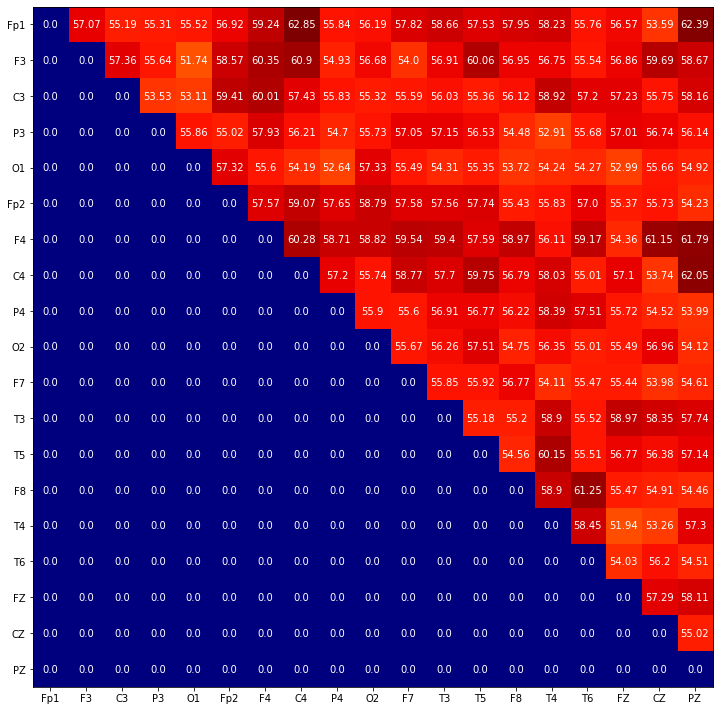

In [10]:
import matplotlib.pyplot as plt
plt.rcParams['image.cmap'] = 'jet' # nipy_spectral, jet

fig, ax = plt.subplots(num=1, clear=True, figsize=(10.0, 10.0))

im = ax.imshow(test)
ax.set_xticks(np.arange(len(idx_to_mont)), labels=idx_to_mont)
ax.set_yticks(np.arange(len(idx_to_mont)), labels=idx_to_mont)
for i in range(len(idx_to_mont)):
    for j in range(len(idx_to_mont)):
        text = ax.text(j, i, round(test[i, j] * 100) / 100,
                       ha="center", va="center", color="w")
fig.tight_layout()
plt.show()

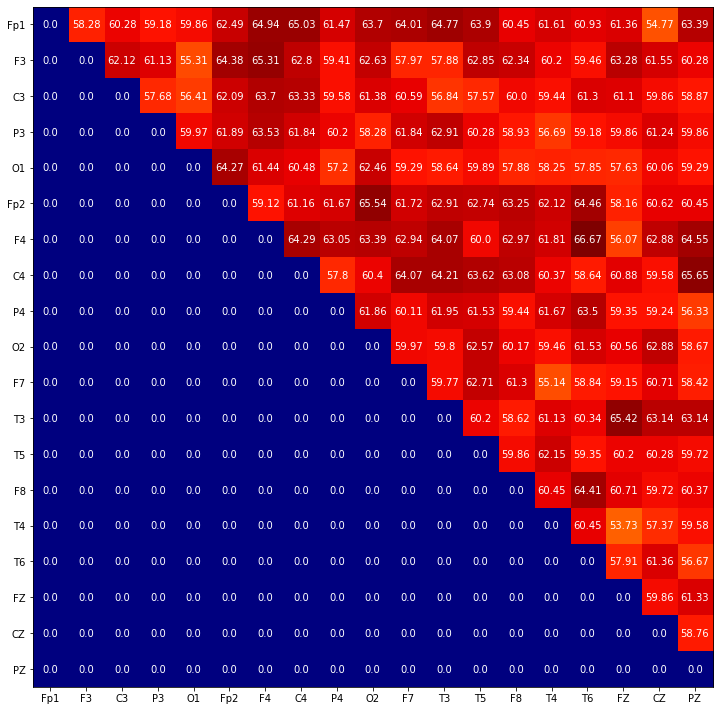

In [11]:
fig, ax = plt.subplots(num=1, clear=True, figsize=(10.0, 10.0))

im = ax.imshow(mtest)
ax.set_xticks(np.arange(len(idx_to_mont)), labels=idx_to_mont)
ax.set_yticks(np.arange(len(idx_to_mont)), labels=idx_to_mont)
for i in range(len(idx_to_mont)):
    for j in range(len(idx_to_mont)):
        text = ax.text(j, i, round(mtest[i, j] * 100) / 100,
                       ha="center", va="center", color="w")
fig.tight_layout()
plt.show()